<a href="https://colab.research.google.com/github/deployr-ai/.github/blob/main/TRABAJO_FINAL_Seminario_de_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABAJO FINAL - Seminario de analytics
El presente informe tiene como objetivo presentar el desarrollo y evaluación de un sistema de clasificación de imágenes utilizando técnicas de procesamiento de imágenes y aprendizaje automático. En este proyecto, se trabajó con un conjunto de imágenes seleccionado previamente y que puede ser reemplazado por otro conjunto a elección del usuario.

El proceso de clasificación de imágenes se llevó a cabo mediante la implementación de dos algoritmos distintos: **MobileNetV2** y **ResNet**. Estos modelos, que pertenecen a la familia de redes neuronales convolucionales, son ampliamente utilizados en tareas de clasificación de imágenes debido a su eficacia y precisión.  MobileNetV2 es más adecuado para dispositivos con recursos limitados y aplicaciones donde la velocidad es una prioridad, mientras que ResNet50 es más potente y puede lograr una mayor precisión en la clasificación, aunque puede requerir más recursos de cómputo.


## Obtención del dataset de imágenes (Opcional)
A continuación se presenta el código para bajar las imágenes desde una fuente pública (Google APIs). Como alternativa, el usuario puede subir una carpeta con imagenes que desee, siempre y cuando respete la siguiente estructura de directorios:
```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```  

En el siguiente ejemplo, las imágenes se guardarán en el directorio *noodles_v1.2*

In [1]:
import os
import tempfile
import zipfile

_DATASET_URL = 'https://storage.googleapis.com/infuseai-auto-img-cls/datasets/noodles_v1.2.zip'

!wget $_DATASET_URL

basename = os.path.basename(_DATASET_URL)

with zipfile.ZipFile(basename, 'r') as zip_ref:
    zip_ref.extractall(".")

base, ext = os.path.splitext(basename)
dataset_dir = f"{base}"
print(f"dataset dir: {dataset_dir}")

--2023-07-31 22:33:40--  https://storage.googleapis.com/infuseai-auto-img-cls/datasets/noodles_v1.2.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124576005 (119M) [application/zip]
Saving to: ‘noodles_v1.2.zip’

noodles_v1.2.zip    100%[===================>] 118.80M  24.3MB/s    in 6.1s    

2023-07-31 22:33:47 (19.4 MB/s) - ‘noodles_v1.2.zip’ saved [124576005/124576005]

dataset dir: noodles_v1.2


# Clasificador de imágenes
Primero desarrollamos una clase llamada *ImageClassifier* la cual podrá invocar uno de los modelos presentados anteriormente, preprocesar las imágenes, realizar el entrenamiento y finalmente clasificar imágenes.

In [2]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np

class ImageClassifier:
    def __init__(self, model_type='MobileNetV2'):
        self.model_type = model_type
        self.model = None
        self.image_size = (224, 224)
        self.class_names = None

    def build_model(self):
        if self.model_type == 'MobileNetV2':
            base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif self.model_type == 'ResNet50':
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        else:
            raise ValueError("Invalid model type. Use 'MobileNetV2' or 'ResNet50'.")

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(len(self.class_names), activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=predictions)

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, dataset_dir, batch_size=32, epochs=10):
        # Step 1: Create a data generator for training and validation
        datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=self.preprocess_input)

        train_generator = datagen.flow_from_directory(
            dataset_dir,
            target_size=self.image_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='training'
        )

        validation_generator = datagen.flow_from_directory(
            dataset_dir,
            target_size=self.image_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation'
        )

        self.class_names = list(train_generator.class_indices.keys())

        # Step 2: Build the model
        self.build_model()

        # Step 3: Start training
        self.model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    def preprocess_input(self, image):
        if self.model_type == 'MobileNetV2':
            return tf.keras.applications.mobilenet_v2.preprocess_input(image)
        elif self.model_type == 'ResNet50':
            return tf.keras.applications.resnet50.preprocess_input(image)
        else:
            raise ValueError("Invalid model type. Use 'MobileNetV2' or 'ResNet50'.")

    def predict(self, img_path):
        with Image.open(img_path) as image:
            image = image.resize(self.image_size).convert("RGB")
            x = tf.keras.preprocessing.image.img_to_array(image)
            x = np.expand_dims(x, 0)
        x = self.preprocess_input(x)
        result = self.model.predict(x)
        cls_idx = int(np.argmax(result, axis=-1))
        cls = self.class_names[cls_idx]
        return (cls, result[0])

## Modelo 1: MobileNetV2
Ahora utilizamos la clase definida anteriormente y realizamos un entrenamiento aplicando el modelo **MobileNetV2** con las imagenes alojadas en *noodles_v1.2*. Luego clasificamos una imagen utilizando el modelo entrenado.



In [3]:

classifier_1 = ImageClassifier(model_type='MobileNetV2')
dataset_dir = '/content/noodles_v1.2' #COLOCAR DIRECCIÓN DE CARPETA CON IMAGENES PARA ENTRENAMIENTO
batch_size = 32
epochs = 5
classifier_1.train(dataset_dir, batch_size, epochs)


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
8/8 [==============================] - 63s 2s/step - loss: 1.1360 - accuracy: 0.6375 - val_loss: 0.2790 - val_accuracy: 0.9500
Epoch 2/5
8/8 [==============================] - 8s 996ms/step - loss: 0.0690 - accuracy: 0.9708 - val_loss: 0.1230 - val_accuracy: 0.9833
Epoch 3/5
8/8 [==============================] - 8s 1s/step - loss: 0.0416 - accuracy: 0.9958 - val_loss: 0.0317 - val_accuracy: 0.9833
Epoch 4/5
8/8 [==============================] - 8s 1s/step - loss: 0.0293 - accuracy: 0.9958 - val_loss: 0.3122 - val_accuracy: 0.9500
Epoch 5/5
8/8 [==============================] - 7s 1s/step - loss: 0.0833 - accuracy: 0.9708 - val_loss: 1.5687 - val_accuracy: 0.8833


Ahora que tenemos el modelo entrenado, vamos a clasificar una imagen que el algoritmo no conoce. Para ello vamos a crear un directorio "test" y vamos a subir manualmente una foto.

1/1 [==============================] - 1s 1s/step


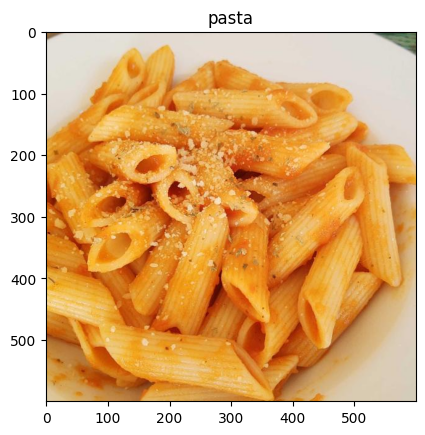

predict: pasta
class_names: ['beef_noodle', 'pasta', 'ramen']
probability: [5.8198706e-19 1.0000000e+00 3.0961913e-15]


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img

_IMG_PATH="/content/test/pasta_al_pomodoro_75549_600_square.jpg" #COLOCAR UBICACION DE LA IMAGEN A CLASIFICAR

image = img.imread(_IMG_PATH)
cls, probs = classifier_1.predict(_IMG_PATH)

plt.title(cls)
plt.imshow(image)
plt.show()

print(f"predict: {cls}")
print(f"class_names: {classifier_1.class_names}")
print(f"probability: {probs}")

In [32]:
probs

array([9.9987638e-01, 5.3485986e-11, 1.2365702e-04], dtype=float32)

In [33]:
sum(probs)

1.0000000370444546

## Modelo 2: ResNet
Ahora vamos a probar con el modelo ResNet. En el siguiente código invocamos y entrenamos este modelo con las mismas imágenes que usamos anteriormente.



In [5]:
classifier_2 = ImageClassifier(model_type='ResNet50')
dataset_dir = '/content/noodles_v1.2' #COLOCAR DIRECCIÓN DE CARPETA CON IMAGENES PARA ENTRENAMIENTO
batch_size = 32
epochs = 5
classifier_2.train(dataset_dir, batch_size, epochs)


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
8/8 [==============================] - 66s 2s/step - loss: 1.1173 - accuracy: 0.7208 - val_loss: 4406.2881 - val_accuracy: 0.5000
Epoch 2/5
8/8 [==============================] - 9s 1s/step - loss: 0.6382 - accuracy: 0.8750 - val_loss: 13140.5488 - val_accuracy: 0.3333
Epoch 3/5
8/8 [==============================] - 9s 1s/step - loss: 0.8684 - accuracy: 0.8750 - val_loss: 287397.0312 - val_accuracy: 0.3333
Epoch 4/5
8/8 [==============================] - 9s 1s/step - loss: 0.2229 - accuracy: 0.9375 - val_loss: 3310.7773 - val_accuracy: 0.4167
Epoch 5/5
8/8 [==============================] - 9s 1s/step - loss: 0.3121 - accuracy: 0.9250 - val_loss: 658.5883 - val_accuracy: 0.3333


Una vez entrenado el modelo, procedemos a realizar una predicción con la misma imagen usada en el ejemplo anterior.

1/1 [==============================] - 1s 1s/step


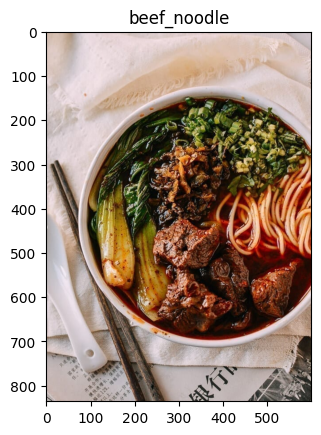

predict: beef_noodle
class_names: ['beef_noodle', 'pasta', 'ramen']
probability: [1. 0. 0.]


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as img

_IMG_PATH="/content/test/taiwanese-beef-noodle-soup-instant-pot-9.jpg" #COLOCAR DIRECCIÓN DE IMAGEN PARA CLASIFICAR

image = img.imread(_IMG_PATH)
cls, probs = classifier_2.predict(_IMG_PATH)

plt.title(cls)
plt.imshow(image)
plt.show()

print(f"predict: {cls}")
print(f"class_names: {classifier_2.class_names}")
print(f"probability: {probs}")

# Implementación
Para llevar a producción este modelo, se sugiere implementar una arquitectura cloud que contenga los componentes que se detallan a continuación. A modo de ejemplo, se utilizaron servicios de AWS.
- Amazon API Gateway: Crea una API para recibir las solicitudes de los usuarios que contienen las imágenes a clasificar. API Gateway actuará como punto de entrada para las solicitudes entrantes y dirigirá el tráfico al siguiente paso.
- Amazon Lambda: El servicio Lambda actuará como el procesador para las solicitudes entrantes y se encargará de lo siguiente:
  - Recibir la imagen de la solicitud HTTP.
  - Preprocesar la imagen si es necesario (por ejemplo, redimensionarla, normalizarla).
  - Realizar una llamada al SageMaker Endpoint para realizar la inferencia.
  - Recibir la predicción del modelo.
  - Postprocesar la predicción si es necesario (por ejemplo, decodificar las etiquetas de clasificación).
  - Devolver la respuesta con la predicción a través de la API Gateway.
- SageMaker Endpoint: Este es el punto final donde se aloja el modelo entrenado. La función Lambda invocará este endpoint para realizar la inferencia.
- Amazon S3: Este servicio sirve para almacenar las imágenes procesadas o resultados de inferencia.
- Base de Datos: Se recomienda almacenar los resultados de la clasificación de imágenes utilizando Amazon DynamoDB.
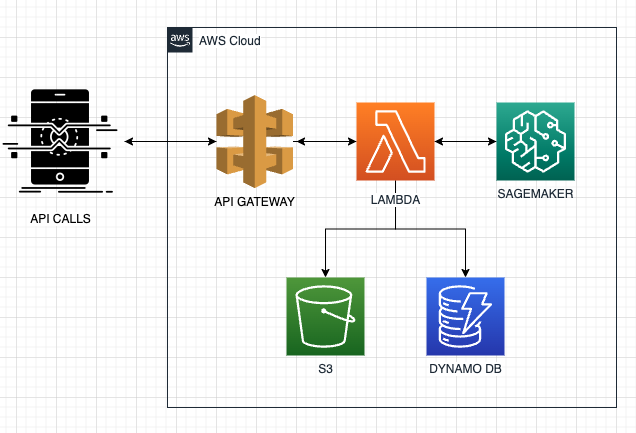

# Conclusiones
En este proyecto de clasificación de imágenes, se han utilizado dos modelos de aprendizaje automático, MobileNetV2 y ResNet50, para clasificar imágenes en diferentes categorías. Después de explorar y preprocesar adecuadamente el conjunto de datos, se entrenaron ambos modelos con la misma cantidad de epochs para realizar una comparación justa de su rendimiento.

Se observó que el modelo ResNet50 tuvo un mejor rendimiento en términos de precisión de clasificación en comparación con MobileNetV2, incluso con la misma cantidad de epochs de entrenamiento. Esto puede deberse a que ResNet50 tiene una arquitectura más profunda y compleja que MobileNetV2, lo que le permite aprender características más específicas y sofisticadas de las imágenes.

## Oportunidades de mejora:

- Aumentar el tamaño del conjunto de datos: Si bien los modelos entrenados obtuvieron resultados aceptables, aumentar el tamaño del conjunto de datos de entrenamiento puede mejorar aún más el rendimiento de los modelos. Un conjunto de datos más grande proporcionará más variedad y complejidad en las imágenes, lo que ayudará a los modelos a generalizar mejor.

- Contemplar el uso de una clase "others" que contenga los casos que el modelo no pudo clasificar.

- Ajustar hiperparámetros: Experimentar con diferentes tasas de aprendizaje, tasas de dropout y tamaños de lote puede afectar significativamente el rendimiento de los modelos. Ajustar estos hiperparámetros puede ayudar a encontrar una configuración óptima para cada modelo.

## Posibles trabajos futuros:

- Explorar otros modelos: Además de MobileNetV2 y ResNet50, existen muchos otros modelos de aprendizaje automático que se pueden probar, como Inception, VGG, EfficientNet, entre otros. Investigar y evaluar otros modelos podría proporcionar aún más información sobre cuál es el más adecuado para este conjunto de datos específico.

- Transfer learning: Utilizar transfer learning es una técnica donde se toma un modelo pre-entrenado en un conjunto de datos grande y se ajusta para una tarea específica con un conjunto de datos más pequeño. Probar diferentes modelos pre-entrenados y realizar transfer learning puede mejorar la eficiencia del entrenamiento y el rendimiento de los modelos.

- Ensamblado de modelos: Combinar las predicciones de varios modelos (ensamblado) puede mejorar el rendimiento general del sistema de clasificación. Implementar técnicas de ensamblado, como votación mayoritaria o promedio de probabilidades, puede proporcionar una mejora significativa en la precisión de las predicciones.

- A/B Testing: Se puede realizar un A/B testing comparando estos modelos entre sí o comparar 1 modelo versus 1 humano. Esto nos permitiría contar con una métrica productiva que indique efectivamente qué tan bueno es el modelo en producción. Al realizar pruebas comparativas, se puede obtener información valiosa sobre el rendimiento real de los modelos en situaciones reales y cómo se comparan con otras opciones, incluida la capacidad humana de clasificación.